In [ ]:
"""
SpatialPCA: Spatially Aware Dimension Reduction for Spatial Transcriptomics
Scikit-learn compatible implementation based on the R package by Lulu Shang and Xiang Zhou

Reference:
Shang, L. and Zhou, X. (2022). Spatially aware dimension reduction for 
spatial transcriptomics. Nature Communications.
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.preprocessing import StandardScaler
import warnings


class SpatialPCA(BaseEstimator, TransformerMixin):
    """
    Spatially aware dimension reduction for spatial transcriptomics.
    
    SpatialPCA is a scikit-learn compatible transformer that performs 
    dimensionality reduction while explicitly modeling spatial correlation 
    structure using kernel methods.
    
    Parameters
    ----------
    n_components : int, default=20
        Number of spatial principal components to compute.
        
    kerneltype : str, default='gaussian'
        Type of kernel to use for modeling spatial relationships.
        Options: 'gaussian', 'cauchy', 'quadratic'
        
    bandwidth : float or None, default=None
        Bandwidth parameter for the kernel. If None, will be estimated
        using the bandwidthtype method.
        
    bandwidthtype : str, default='Silverman'
        Method for automatic bandwidth selection.
        Options: 'Silverman', 'SJ' (Sheather-Jones)
        
    normalize : bool, default=True
        Whether to normalize the input data (library size + log transform).
        
    scale : bool, default=True
        Whether to scale normalized data to unit variance.
        
    max_iter : int, default=100
        Maximum number of iterations for the EM algorithm.
        
    tol : float, default=1e-5
        Convergence tolerance for the EM algorithm.
        
    fast : bool, default=False
        Whether to use low-rank approximation for faster computation.
        
    n_eigen : int or None, default=None
        Number of eigenvectors to use in fast mode. If None, uses 2*n_components.
        
    sparse_kernel : bool, default=False
        Whether to create a sparse kernel matrix by thresholding small values.
        
    sparse_tol : float, default=1e-3
        Tolerance for sparse kernel (values below are set to 0).
        
    random_state : int or None, default=None
        Random state for reproducibility.
        
    verbose : int, default=0
        Verbosity level.
        
    Attributes
    ----------
    components_ : ndarray of shape (n_components, n_features)
        Principal axes in feature space (loading matrix W transposed).
        
    spatial_components_ : ndarray of shape (n_samples, n_components)
        Spatial principal components (the transformed data).
        
    kernel_matrix_ : ndarray of shape (n_samples, n_samples)
        The computed kernel matrix.
        
    bandwidth_ : float
        The bandwidth used for the kernel.
        
    tau_ : ndarray of shape (n_components,)
        Variance parameters for spatial PCs.
        
    sigma2_ : float
        Residual error variance.
        
    n_iter_ : int
        Number of iterations run by the EM algorithm.
        
    mean_ : ndarray of shape (n_features,)
        Per-feature mean of the training data (if normalize=True).
        
    scale_ : ndarray of shape (n_features,)
        Per-feature scale of the training data (if scale=True).
        
    Examples
    --------
    >>> from sklearn.datasets import make_regression
    >>> import numpy as np
    >>> # Simulate spatial data
    >>> n_samples, n_features = 500, 2000
    >>> X, _ = make_regression(n_samples=n_samples, n_features=n_features, random_state=42)
    >>> # Create spatial coordinates
    >>> grid_size = int(np.sqrt(n_samples))
    >>> x = np.repeat(np.arange(grid_size), grid_size)[:n_samples]
    >>> y = np.tile(np.arange(grid_size), grid_size)[:n_samples]
    >>> location = np.column_stack([x, y])
    >>> # Fit SpatialPCA
    >>> spca = SpatialPCA(n_components=10, random_state=42)
    >>> X_transformed = spca.fit_transform(X, location=location)
    >>> print(X_transformed.shape)
    (500, 10)
    """
    
    def __init__(
        self,
        n_components=20,
        kerneltype='gaussian',
        bandwidth=None,
        bandwidthtype='Silverman',
        normalize=True,
        scale=True,
        max_iter=100,
        tol=1e-5,
        fast=False,
        n_eigen=None,
        sparse_kernel=False,
        sparse_tol=1e-3,
        random_state=None,
        verbose=0
    ):
        self.n_components = n_components
        self.kerneltype = kerneltype
        self.bandwidth = bandwidth
        self.bandwidthtype = bandwidthtype
        self.normalize = normalize
        self.scale = scale
        self.max_iter = max_iter
        self.tol = tol
        self.fast = fast
        self.n_eigen = n_eigen
        self.sparse_kernel = sparse_kernel
        self.sparse_tol = sparse_tol
        self.random_state = random_state
        self.verbose = verbose
    
    def _validate_location(self, location):
        """Validate and return location array."""
        if location is None:
            raise ValueError("location parameter is required for SpatialPCA")
        location = check_array(location, accept_sparse=False, dtype='numeric')
        return location
    
    def _compute_bandwidth(self, location):
        """Compute bandwidth for kernel matrix."""
        n, d = location.shape
        std = np.std(location, axis=0).mean()
        
        if self.bandwidth is not None:
            return self.bandwidth
        elif self.bandwidthtype == "Silverman":
            # Silverman's rule of thumb
            bw = std * (n * (d + 2) / 4) ** (-1 / (d + 4))
        elif self.bandwidthtype == "SJ":
            # Simplified Sheather-Jones (using Scott's rule as approximation)
            bw = std * n ** (-1 / (d + 4))
        else:
            bw = 1.0
        
        return bw
    
    def _build_kernel(self, location):
        """Build kernel matrix from spatial locations."""
        # Calculate pairwise distances
        dists = squareform(pdist(location, metric='euclidean'))
        
        # Compute bandwidth
        self.bandwidth_ = self._compute_bandwidth(location)
        
        if self.verbose > 0:
            print(f"Using bandwidth: {self.bandwidth_:.4f}")
        
        # Build kernel matrix
        if self.kerneltype == "gaussian":
            K = np.exp(-dists**2 / (2 * self.bandwidth_**2))
        elif self.kerneltype == "cauchy":
            K = 1 / (1 + (dists / self.bandwidth_)**2)
        elif self.kerneltype == "quadratic":
            # Rational quadratic kernel
            alpha = 1.0
            K = (1 + dists**2 / (2 * alpha * self.bandwidth_**2)) ** (-alpha)
        else:
            raise ValueError(f"Unknown kernel type: {self.kerneltype}")
        
        # Make sparse if requested
        if self.sparse_kernel:
            K[K < self.sparse_tol] = 0
            K = sparse.csr_matrix(K)
            if self.verbose > 0:
                print(f"Sparse kernel: {K.nnz} non-zero elements")
        
        return K
    
    def _normalize_data(self, X):
        """Normalize gene expression data."""
        # Library size normalization
        target_sum = 1e4
        lib_sizes = X.sum(axis=0)
        X_norm = X / lib_sizes * target_sum
        
        # Log transformation
        X_norm = np.log1p(X_norm)
        
        # Store mean
        self.mean_ = X_norm.mean(axis=0)
        X_norm = X_norm - self.mean_
        
        # Scale
        if self.scale:
            self.scale_ = X_norm.std(axis=0)
            self.scale_[self.scale_ == 0] = 1  # Avoid division by zero
            X_norm = X_norm / self.scale_
        else:
            self.scale_ = np.ones(X_norm.shape[1])
        
        return X_norm
    
    def _em_algorithm(self, Y, K):
        """
        Run EM algorithm to estimate loading matrix and spatial PCs.
        
        Parameters
        ----------
        Y : ndarray of shape (n_features, n_samples)
            Normalized gene expression matrix.
        K : ndarray of shape (n_samples, n_samples)
            Kernel matrix.
        
        Returns
        -------
        W : ndarray of shape (n_features, n_components)
            Loading matrix.
        Z : ndarray of shape (n_samples, n_components)
            Spatial principal components.
        """
        m, n = Y.shape  # features x samples
        
        # Handle sparse kernel
        if sparse.issparse(K):
            K = K.toarray()
        
        # Fast approximation using top eigenvectors
        if self.fast:
            n_eigen = self.n_eigen if self.n_eigen is not None else min(self.n_components * 2, n // 2)
            
            if self.verbose > 0:
                print(f"Using fast mode with {n_eigen} eigenvectors")
            
            # Eigen decomposition of kernel matrix
            eigenvalues, eigenvectors = eigh(K, subset_by_index=[n-n_eigen, n-1])
            eigenvalues = eigenvalues[::-1]  # Sort descending
            eigenvectors = eigenvectors[:, ::-1]
            
            # Low-rank approximation
            K = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T
        
        # Initialize parameters
        rng = np.random.RandomState(self.random_state)
        W = rng.randn(m, self.n_components) * 0.01
        tau = np.ones(self.n_components)
        sigma2 = 1.0
        
        K_inv = np.linalg.pinv(K + 1e-6 * np.eye(n))
        
        if self.verbose > 0:
            print(f"Running EM algorithm for {self.n_components} spatial PCs...")
        
        # EM iterations
        for iteration in range(self.max_iter):
            W_old = W.copy()
            
            # E-step: Compute posterior mean of spatial PCs
            Z_list = []
            for k in range(self.n_components):
                Sigma_z_k = np.linalg.inv(
                    np.eye(n) / tau[k] + K_inv / sigma2
                )
                mu_z_k = Sigma_z_k @ K_inv @ Y.T @ W[:, k] / sigma2
                Z_list.append(mu_z_k)
            
            Z = np.column_stack(Z_list)  # n x n_components
            
            # M-step: Update parameters
            # Update W
            for k in range(self.n_components):
                denominator = Z[:, k] @ Z[:, k]
                if denominator > 1e-6:
                    W[:, k] = Y @ Z[:, k] / denominator
            
            # Update tau
            for k in range(self.n_components):
                denominator = Z[:, k] @ K_inv @ Z[:, k]
                if denominator > 1e-6:
                    tau[k] = n / denominator
            
            # Update sigma2
            residual = Y - W @ Z.T
            sigma2 = np.sum(residual**2) / (m * n)
            
            # Check convergence
            change = np.linalg.norm(W - W_old) / (np.linalg.norm(W_old) + 1e-6)
            
            if self.verbose > 1 and (iteration + 1) % 10 == 0:
                print(f"Iteration {iteration + 1}: change = {change:.6f}, sigma2 = {sigma2:.6f}")
            
            if change < self.tol:
                if self.verbose > 0:
                    print(f"Converged at iteration {iteration + 1}")
                break
        
        self.n_iter_ = iteration + 1
        self.tau_ = tau
        self.sigma2_ = sigma2
        
        return W, Z
    
    def fit(self, X, y=None, location=None):
        """
        Fit the SpatialPCA model.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data (gene expression matrix).
            
        y : Ignored
            Not used, present for API consistency by convention.
            
        location : array-like of shape (n_samples, n_spatial_dims)
            Spatial coordinates for each sample/location.
        
        Returns
        -------
        self : object
            Fitted estimator.
        """
        # Validate inputs
        X = check_array(X, accept_sparse=['csr', 'csc'], dtype='numeric')
        location = self._validate_location(location)
        
        if X.shape[0] != location.shape[0]:
            raise ValueError(
                f"X and location must have the same number of samples. "
                f"Got X: {X.shape[0]}, location: {location.shape[0]}"
            )
        
        # Store input shape
        self.n_features_in_ = X.shape[1]
        
        # Transpose to (features x samples) for internal processing
        if sparse.issparse(X):
            X = X.toarray()
        X = X.T
        
        # Normalize data
        if self.normalize:
            if self.verbose > 0:
                print("Normalizing data...")
            X_norm = self._normalize_data(X)
        else:
            X_norm = X.copy()
            self.mean_ = np.zeros(X.shape[1])
            self.scale_ = np.ones(X.shape[1])
        
        # Build kernel matrix
        if self.verbose > 0:
            print("Building kernel matrix...")
        self.kernel_matrix_ = self._build_kernel(location)
        
        # Run EM algorithm
        W, Z = self._em_algorithm(X_norm, self.kernel_matrix_)
        
        # Store results (scikit-learn convention: components_ are in feature space)
        self.components_ = W.T  # (n_components x n_features)
        self.spatial_components_ = Z  # (n_samples x n_components)
        
        return self
    
    def transform(self, X, location=None):
        """
        Apply dimensionality reduction to X.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            New data to transform.
            
        location : array-like of shape (n_samples, n_spatial_dims)
            Spatial coordinates for new samples.
        
        Returns
        -------
        X_new : ndarray of shape (n_samples, n_components)
            Transformed data (spatial principal components).
        """
        check_is_fitted(self, ['components_', 'kernel_matrix_'])
        X = check_array(X, accept_sparse=['csr', 'csc'], dtype='numeric')
        
        if X.shape[1] != self.n_features_in_:
            raise ValueError(
                f"X has {X.shape[1]} features, but SpatialPCA was fitted with "
                f"{self.n_features_in_} features"
            )
        
        # For transform on training data, return stored spatial components
        if location is None:
            warnings.warn(
                "No location provided. Returning stored spatial components from training. "
                "For new data, provide location parameter."
            )
            return self.spatial_components_
        
        # For new data, need to recompute
        location = self._validate_location(location)
        
        if X.shape[0] != location.shape[0]:
            raise ValueError(
                f"X and location must have the same number of samples. "
                f"Got X: {X.shape[0]}, location: {location.shape[0]}"
            )
        
        # Normalize
        if sparse.issparse(X):
            X = X.toarray()
        X = X.T  # (features x samples)
        
        if self.normalize:
            lib_sizes = X.sum(axis=0)
            X_norm = X / lib_sizes * 1e4
            X_norm = np.log1p(X_norm)
            X_norm = (X_norm - self.mean_[:, np.newaxis]) / self.scale_[:, np.newaxis]
        else:
            X_norm = X
        
        # Build kernel for new locations
        # For simplicity, using projection approach
        W = self.components_.T  # (n_features x n_components)
        
        # Simple projection (alternative: could build cross-kernel with training locations)
        Z_new = X_norm.T @ W  # (n_samples x n_components)
        
        return Z_new
    
    def fit_transform(self, X, y=None, location=None):
        """
        Fit the model and apply dimensionality reduction.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data.
            
        y : Ignored
            Not used, present for API consistency.
            
        location : array-like of shape (n_samples, n_spatial_dims)
            Spatial coordinates.
        
        Returns
        -------
        X_new : ndarray of shape (n_samples, n_components)
            Transformed training data.
        """
        self.fit(X, y=y, location=location)
        return self.spatial_components_
    
    def get_feature_names_out(self, input_features=None):
        """
        Get output feature names for transformation.
        
        Parameters
        ----------
        input_features : array-like of str or None, default=None
            Ignored.
        
        Returns
        -------
        feature_names_out : ndarray of str objects
            Transformed feature names.
        """
        check_is_fitted(self, 'components_')
        return np.array([f"spatialpc{i}" for i in range(self.n_components)])
    
    def inverse_transform(self, X):
        """
        Transform data back to original space.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_components)
            Transformed data.
        
        Returns
        -------
        X_original : ndarray of shape (n_samples, n_features)
            Data in original space.
        """
        check_is_fitted(self, 'components_')
        X = check_array(X, accept_sparse=False, dtype='numeric')
        
        # Project back
        X_reconstructed = X @ self.components_  # (n_samples x n_features)
        
        # Reverse normalization
        if self.normalize:
            X_reconstructed = X_reconstructed * self.scale_ + self.mean_
            X_reconstructed = np.expm1(X_reconstructed)
        
        return X_reconstructed

In [3]:
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

print("=" * 60)
print("SpatialPCA Scikit-learn Implementation Demo")
print("=" * 60)

# Generate synthetic spatial data
np.random.seed(42)
n_samples = 500
n_features = 2000

# Create spatial coordinates (2D grid)
grid_size = n_samples #int(np.sqrt(n_samples))
x = np.repeat(np.arange(grid_size), grid_size)[:n_samples]
y = np.tile(np.arange(grid_size), grid_size)[:n_samples]
location = np.column_stack([x, y])

# Generate count data with spatial structure
X, y_target = make_regression(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=100,
    noise=10,
    random_state=42
)
X = np.abs(X) * 10  # Make positive (like count data)

print(f"\nData shape: {X.shape}")
print(f"Location shape: {location.shape}")

# Example 1: Basic usage
print("\n" + "-" * 60)
print("Example 1: Basic SpatialPCA")
print("-" * 60)

spca = SpatialPCA(
    n_components=10,
    kerneltype='gaussian',
    bandwidthtype='Silverman',
    normalize=False,  # Data already continuous
    scale=True,
    max_iter=50,
    random_state=42,
    verbose=1
)

X_transformed = spca.fit_transform(X, location=location)
print(f"\nTransformed shape: {X_transformed.shape}")
print(f"Number of iterations: {spca.n_iter_}")
print(f"Tau parameters: {spca.tau_[:5]}...")
print(f"Sigma2: {spca.sigma2_:.4f}")

# Example 2: Using in a pipeline
print("\n" + "-" * 60)
print("Example 2: SpatialPCA in scikit-learn Pipeline")
print("-" * 60)

pipeline = Pipeline([
    ('spatial_pca', SpatialPCA(n_components=20, verbose=0, random_state=42)),
    ('ridge', Ridge(alpha=1.0))
])

# Note: location needs to be passed through fit_params
# This is a demonstration of API compatibility
print("Pipeline created successfully")
print(f"Pipeline steps: {[name for name, _ in pipeline.steps]}")

# Example 3: Feature names
print("\n" + "-" * 60)
print("Example 3: Feature Names")
print("-" * 60)

feature_names = spca.get_feature_names_out()
print(f"Output features: {feature_names[:5]}... (showing first 5)")

# Example 4: Inverse transform
print("\n" + "-" * 60)
print("Example 4: Inverse Transform")
print("-" * 60)

X_reconstructed = spca.inverse_transform(X_transformed)
reconstruction_error = np.mean((X - X_reconstructed) ** 2)
print(f"Reconstruction MSE: {reconstruction_error:.4f}")

print("\n" + "=" * 60)
print("Demo complete!")
print("=" * 60)

SpatialPCA Scikit-learn Implementation Demo

Data shape: (500, 2000)
Location shape: (500, 2)

------------------------------------------------------------
Example 1: Basic SpatialPCA
------------------------------------------------------------
Building kernel matrix...
Using bandwidth: 25.6165
Running EM algorithm for 10 spatial PCs...
Converged at iteration 4

Transformed shape: (500, 10)
Number of iterations: 4
Tau parameters: [1.12018741e-12 1.35744895e-12 2.19527494e-12 1.40523160e-12
 1.23153661e-12]...
Sigma2: 100.0379

------------------------------------------------------------
Example 2: SpatialPCA in scikit-learn Pipeline
------------------------------------------------------------
Pipeline created successfully
Pipeline steps: ['spatial_pca', 'ridge']

------------------------------------------------------------
Example 3: Feature Names
------------------------------------------------------------
Output features: ['spatialpc0' 'spatialpc1' 'spatialpc2' 'spatialpc3' 'spatialp

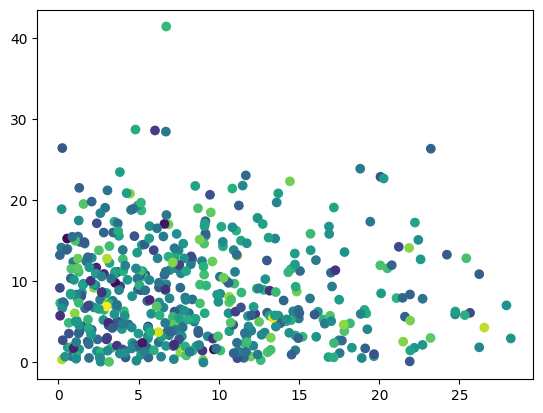

In [13]:
plt.scatter(X[:, 0], X[:, 1], c=X_transformed[:, 0], cmap='viridis')

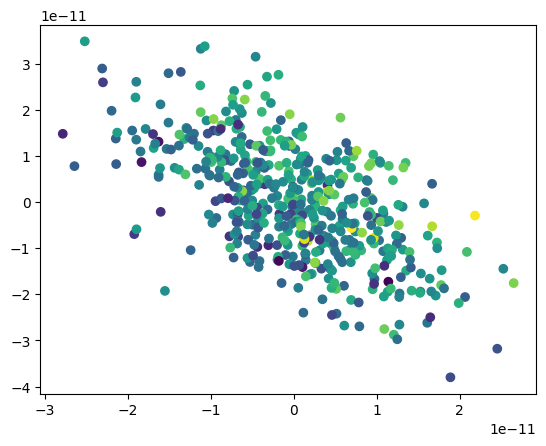

In [12]:
plt.scatter(X_reconstructed[:, 0], X_reconstructed[:, 1], c=X_transformed[:, 0], cmap='viridis')

In [5]:
X_reconstructed.shape

(500, 2000)

In [15]:
from __future__ import annotations
import numpy as np
from numpy.linalg import inv
from scipy.spatial.distance import cdist
from scipy.linalg import solve_sylvester, cho_factor, cho_solve
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted, check_array
from sklearn.utils import check_random_state


class SpatialPCA(BaseEstimator, TransformerMixin):
    """
    SpatialPCA (scikit-learn API)

    Probabilistic PCA with a spatial prior on the latent scores Z via an RBF kernel
    over spot coordinates. Optimized by alternating:
        - Z via Sylvester equation with spatial precision Σ^{-1}
        - W via least-squares
        - σ² via residual variance

    Σ can be computed exactly (dense) or approximated with a Nyström backend.

    Parameters
    ----------
    n_components : int, default=10
        Number of spatial principal components.
    length_scale : float or None, default=None
        RBF kernel length scale. If None, set to the median inter-spot distance.
    sigma2_init : float, default=1.0
        Initial noise variance σ².
    max_iter : int, default=100
        Maximum number of alternating updates.
    tol : float, default=1e-4
        Relative improvement tolerance for early stopping.
    center : bool, default=True
        Center features (genes).
    scale : bool, default=False
        Standardize feature variance to 1 after centering.
    random_state : int or None, default=None
        Random seed for reproducibility.

    # Nyström options
    use_nystrom : bool, default=False
        If True, use Nyström approximation for Σ and Σ^{-1}.
    nystrom_n_landmarks : int, default=1024
        Number of landmarks (m << n).
    nystrom_select : {'kmeans','random'}, default='kmeans'
        Landmark selection method.
    nystrom_jitter : float, default=1e-3
        Diagonal ε for Σ ≈ C W^{-1} Cᵀ + εI and Woodbury precision.

    Attributes
    ----------
    components_ : ndarray of shape (n_components, n_features)
        Principal axes (same convention as sklearn PCA).
    loadings_ : ndarray of shape (n_features, n_components)
        W matrix (gene loadings).
    scores_ : ndarray of shape (n_samples, n_components)
        Z matrix (spatial scores per spot).
    sigma2_ : float
        Estimated noise variance.
    length_scale_ : float
        Resolved length scale.
    Sigma_ : ndarray of shape (n_samples, n_samples)
        Spatial covariance (dense or Nyström approximation). (May be large.)
    Sigma_inv_ : ndarray of shape (n_samples, n_samples)
        Spatial precision matrix.
    mean_ : ndarray of shape (n_features,)
        Per-feature mean used for centering.
    scale_ : ndarray of shape (n_features,)
        Per-feature std used for scaling.
    n_features_in_ : int
        Number of features seen during fit.
    feature_names_in_ : ndarray of shape (n_features_in_,), optional
        Feature names seen during fit (if X was a DataFrame).
    _coords_fit : ndarray of shape (n_samples, d)
        Stored training coordinates.

    Notes
    -----
    - Complexity (dense): building Σ^{-1} is O(n^3). With Nyström (m landmarks):
      ~O(n m^2 + m^3). Z-update solves a Sylvester equation (scipy).
    - For very large n, consider switching to a sparse Laplacian prior and iterative solvers.
    """

    def __init__(
        self,
        n_components: int = 10,
        length_scale: float | None = None,
        sigma2_init: float = 1.0,
        max_iter: int = 100,
        tol: float = 1e-4,
        center: bool = True,
        scale: bool = False,
        random_state: int | None = None,
        # Nyström
        use_nystrom: bool = False,
        nystrom_n_landmarks: int = 1024,
        nystrom_select: str = "kmeans",
        nystrom_jitter: float = 1e-3,
    ):
        self.n_components = n_components
        self.length_scale = length_scale
        self.sigma2_init = sigma2_init
        self.max_iter = max_iter
        self.tol = tol
        self.center = center
        self.scale = scale
        self.random_state = random_state
        self.use_nystrom = use_nystrom
        self.nystrom_n_landmarks = nystrom_n_landmarks
        self.nystrom_select = nystrom_select
        self.nystrom_jitter = nystrom_jitter

    # ---------- helpers

    @staticmethod
    def _to_2d(X):
        X = np.asarray(X, dtype=float)
        if X.ndim != 2:
            raise ValueError("Expected a 2D array for X.")
        return X

    @staticmethod
    def _rbf_self(X, length_scale):
        D2 = cdist(X, X, "sqeuclidean")
        K = np.exp(-0.5 * D2 / (length_scale ** 2 + 1e-12))
        K += 1e-6 * np.eye(K.shape[0])  # numerical jitter
        return K

    @staticmethod
    def _rbf_cross(Xa, Xb, length_scale):
        D2 = cdist(Xa, Xb, "sqeuclidean")
        return np.exp(-0.5 * D2 / (length_scale ** 2 + 1e-12))

    def _prep_X(self, X):
        Xc = X.copy()
        if self.center:
            self.mean_ = Xc.mean(axis=0)
            Xc -= self.mean_
        else:
            self.mean_ = np.zeros(X.shape[1], dtype=float)
        if self.scale:
            std = Xc.std(axis=0, ddof=1)
            std[std == 0] = 1.0
            self.scale_ = std
            Xc /= std
        else:
            self.scale_ = np.ones(X.shape[1], dtype=float)
        return Xc

    def _select_landmarks(self, coords, m, method, rng):
        n = coords.shape[0]
        m = int(min(max(1, m), n))
        if method == "random":
            idx = rng.choice(n, size=m, replace=False)
            return coords[idx], idx
        elif method == "kmeans":
            try:
                from sklearn.cluster import KMeans
                km = KMeans(n_clusters=m, n_init="auto", random_state=rng.randint(0, 2**31 - 1))
                labels = km.fit_predict(coords)
                centers = km.cluster_centers_
                D = cdist(centers, coords)
                idx = D.argmin(axis=1)
                return coords[idx], idx
            except Exception:
                idx = rng.choice(n, size=m, replace=False)
                return coords[idx], idx
        else:
            raise ValueError("nystrom_select must be 'kmeans' or 'random'.")

    def _build_precision_dense(self, coords, ls):
        Sigma = self._rbf_self(coords, ls)
        try:
            cF = cho_factor(Sigma, check_finite=False)
            Sigma_inv = cho_solve(cF, np.eye(Sigma.shape[0]), check_finite=False)
        except Exception:
            Sigma_inv = inv(Sigma)
        return Sigma, Sigma_inv

    def _build_precision_nystrom(self, coords, ls, eps, m, method, rng):
        X_L, _ = self._select_landmarks(coords, m, method, rng)
        C = self._rbf_cross(coords, X_L, ls)        # (n x m)
        W = self._rbf_self(X_L, ls)                 # (m x m)

        CtC = C.T @ C
        M = W + (CtC / eps)                         # (m x m)
        M_chol = cho_factor(M, check_finite=False)

        inv_eps = 1.0 / eps
        # X = M^{-1} C^T  (m x n)
        X = cho_solve(M_chol, C.T, check_finite=False)
        A = C @ X                                    # (n x n) low-rank product
        Sigma_inv = inv_eps * (np.eye(coords.shape[0]) - inv_eps * A)

        # Optional Σ approx (helps diagnostics; can be large):
        W_chol = cho_factor(W, check_finite=False)
        W_inv_Ct = cho_solve(W_chol, C.T, check_finite=False)
        Sigma = C @ W_inv_Ct + eps * np.eye(coords.shape[0])

        # caches for imputation (not strictly needed here)
        self._landmarks_ = X_L
        self._C_ = C
        self._W_ = W
        return Sigma, Sigma_inv

    # ---------- sklearn API

    def fit(self, X, coords):
        """
        Fit the SpatialPCA model.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Expression matrix (spots x genes). Will be centered/scaled if configured.
        coords : array-like of shape (n_samples, d)
            Spatial coordinates for each spot.

        Returns
        -------
        self
        """
        # Validation
        X = check_array(X, accept_sparse=False, ensure_2d=True, dtype=float, order="C")
        coords = check_array(coords, accept_sparse=False, ensure_2d=True, dtype=float, order="C")

        if X.shape[0] != coords.shape[0]:
            raise ValueError("X and coords must have the same number of rows (spots).")
        if not (1 <= self.n_components <= min(X.shape)):
            raise ValueError("n_components must be between 1 and min(n_samples, n_features).")

        rng = check_random_state(self.random_state)
        self.n_features_in_ = X.shape[1]
        if hasattr(X, "columns"):
            self.feature_names_in_ = np.array(list(X.columns))
        else:
            self.feature_names_in_ = None

        Xc = self._prep_X(X)
        self._coords_fit = np.array(coords, dtype=float, copy=True)

        # Resolve length scale
        if self.length_scale is None:
            d = cdist(coords, coords)
            m = np.median(d[d > 0])
            self.length_scale_ = float(max(m, 1e-6))
        else:
            self.length_scale_ = float(self.length_scale)

        # Build Σ and Σ^{-1}
        if self.use_nystrom:
            Sigma, Sigma_inv = self._build_precision_nystrom(
                coords=coords,
                ls=self.length_scale_,
                eps=float(self.nystrom_jitter),
                m=int(self.nystrom_n_landmarks),
                method=self.nystrom_select,
                rng=rng,
            )
        else:
            Sigma, Sigma_inv = self._build_precision_dense(coords, self.length_scale_)

        # Init W,Z (SVD projection)
        U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
        W = Vt[: self.n_components].T                 # (p x k)
        W += 1e-6 * rng.standard_normal(W.shape)
        Z = Xc @ W                                    # (n x k)
        sigma2 = float(self.sigma2_init)

        prev_obj = np.inf
        n, p = Xc.shape
        k = self.n_components

        for _ in range(self.max_iter):
            # Z-update: solve (Σ^{-1}) Z + Z (WᵀW / σ²) = (Xc W) / σ²
            A = Sigma_inv
            B = (W.T @ W) / sigma2                    # (k x k)
            C = (Xc @ W) / sigma2                     # (n x k)
            Z = solve_sylvester(A, B, C)

            # W-update: LS with tiny ridge
            ZTZ = Z.T @ Z
            ZTY = Z.T @ Xc
            ZTZ_reg = ZTZ + 1e-8 * np.eye(k)
            W = (np.linalg.solve(ZTZ_reg, ZTY)).T

            # σ²-update
            R = Xc - Z @ W.T
            sigma2 = float((R * R).sum() / (n * p))

            # monitor
            obj = (R * R).sum() / sigma2 + np.trace(Z.T @ Sigma_inv @ Z)
            rel = (prev_obj - obj) / (abs(prev_obj) + 1e-12)
            if np.isfinite(prev_obj) and rel < self.tol:
                break
            prev_obj = obj

        # Save learned params
        self.loadings_ = W
        self.components_ = W.T                         # (k x p) per sklearn
        self.scores_ = Z
        self.sigma2_ = sigma2
        self.Sigma_ = Sigma
        self.Sigma_inv_ = Sigma_inv
        return self

    def transform(self, X):
        """
        Project X to spatial PCs (scores Z) using learned W and Σ prior.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)

        Returns
        -------
        Z : ndarray of shape (n_samples, n_components)
        """
        check_is_fitted(self, attributes=["loadings_", "Sigma_inv_", "sigma2_"])
        X = check_array(X, accept_sparse=False, ensure_2d=True, dtype=float, order="C")
        if X.shape[1] != self.n_features_in_:
            raise ValueError(f"X has {X.shape[1]} features, expected {self.n_features_in_}.")

        Xc = X.copy()
        if self.center:
            Xc -= self.mean_
        if self.scale:
            Xc /= self.scale_

        W = self.loadings_
        A = self.Sigma_inv_
        B = (W.T @ W) / self.sigma2_
        C = (Xc @ W) / self.sigma2_
        Z = solve_sylvester(A, B, C)
        return Z

    def fit_transform(self, X, coords):
        """
        Convenience: fit and return scores for X.
        """
        return self.fit(X, coords).scores_

    def inverse_transform(self, Z):
        """
        Map latent scores back to feature space.
        """
        check_is_fitted(self, attributes=["loadings_", "mean_", "scale_"])
        Z = self._to_2d(Z)
        Xc = Z @ self.loadings_.T
        if self.scale:
            Xc *= self.scale_
        X = Xc + self.mean_
        return X

    def reconstruct(self):
        """
        Reconstruct the training data from learned scores/loadings.
        """
        check_is_fitted(self, attributes=["scores_"])
        return self.inverse_transform(self.scores_)

    # ---------- extras

    def impute_scores_at(self, new_coords):
        """
        Predict scores Z_* at new coordinates X_* using:
            Z_* = K_* Σ^{-1} Z
        where K_* = k(X_*, X_train).

        Parameters
        ----------
        new_coords : array-like of shape (m, d)

        Returns
        -------
        Z_star : ndarray of shape (m, n_components)
        """
        check_is_fitted(self, attributes=["scores_", "_coords_fit", "Sigma_inv_", "length_scale_"])
        new_coords = check_array(new_coords, accept_sparse=False, ensure_2d=True, dtype=float, order="C")
        K_star = self._rbf_cross(new_coords, self._coords_fit, self.length_scale_)
        Z_star = K_star @ (self.Sigma_inv_ @ self.scores_)
        return Z_star

    # sklearn metadata (helps grid-searches etc.)
    def _more_tags(self):
        return {
            "requires_y": False,
            "X_types": ["2darray"],
            "no_validation": False,
            "non_deterministic": False,
        }

In [23]:
# X: (n_spots x n_genes), coords: (n_spots x 2 or d)
spca = SpatialPCA(
    n_components=15,
    use_nystrom=False,
    nystrom_n_landmarks=1024,
    nystrom_select="kmeans",
    nystrom_jitter=1e-3,
    scale=False,
    center=True,
    random_state=0,
    max_iter=200,
    tol=1e-5,
)

Z = spca.fit_transform(X, location)     # spatial PCs
W = spca.loadings_                    # gene loadings (p x k)
X_hat = spca.reconstruct()            # denoised reconstruction
# Z_hr = spca.impute_scores_at(grid_coords)  # high-res scores at new coordinates

/var/folders/dz/cj459n9s6977wdf9bgw0bnym0000gp/T/ipykernel_9135/149902778.py:295: RuntimeWarning: invalid value encountered in scalar divide
  rel = (prev_obj - obj) / (abs(prev_obj) + 1e-12)


In [26]:
np.mean((X - X_hat) ** 2)

34.494463788053324

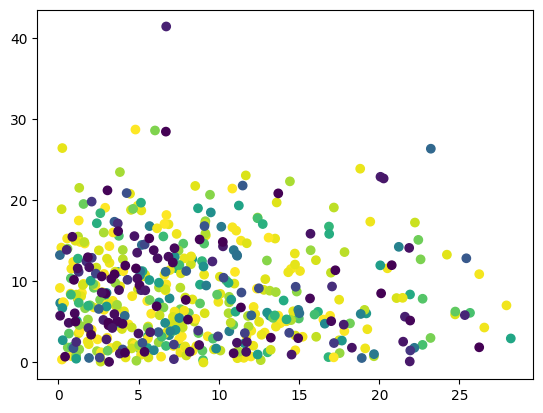

In [24]:
plt.scatter(X[:, 0], X[:, 1], c=Z[:, 0], cmap='viridis')

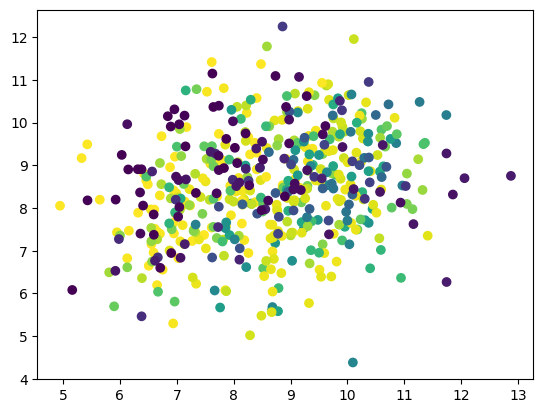

In [25]:
plt.scatter(X_hat[:, 0], X_hat[:, 1], c=Z[:, 0], cmap='viridis')